<a href="https://colab.research.google.com/github/niikun/DL_for_health_care/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1
## Overview
データを準備し、基本的な統計量を計算し、簡単なモデルを構築することは、データサイエンスの実践に不可欠なステップです。この宿題では、心不全予測を実行するための生の入力として臨床データを使用します。この宿題ではPythonプログラミングが必要です。プログラミング問題のスタートポイントとして、添付のスケルトンコードを参照してください。

この宿題はPandasに精通していることを前提としています。Pandasのクラッシュコースが必要な場合は、100 Pandas Puzzlesに取り組むことをお勧めします。

```python
import pandas as pd
import numpy as np
import base64

df1 = pd.read_csv("PATH/event_feature_map.csv")
df2 = pd.read_csv("PATH/events.csv")
df3 = pd.read_csv("PATH/hf_events.csv")
df1.to_csv("event_feature_map.csv")
df2.to_csv("events.csv")
df3.to_csv("hf_events.csv")

from IPython.display import HTML

def create_download_link(df, title="Download CSV file", filename="processed_file.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()  # CSVをbase64エンコード
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">{title}</a>'
    return HTML(href)

# ダウンロードリンクの表示
create_download_link(df3)
```

## About Raw Data
この宿題では、[MIMIC-III](https://www.nature.com/articles/sdata201635)から合成した臨床データセットを使用する。
https://www.nature.com/articles/sdata201635

**events.csv**  
events.csvで提供されるデータは、イベント・シーケンスである。このファイルの各行は、(pid, event_id, vid, value)という形式のタプルで構成されています。

例えば  

```
33,DIAG_244,0,1
33,DIAG_414,0,1
33,DIAG_427,0,1
33,LAB_50971,0,1
33,LAB_50931,0,1
33,LAB_50812,1,1
33,DIAG_425,1,1
33,DIAG_427,1,1
33,DRUG_0,1,1
33,DRUG_3,1,1
```
- pid： 非特定患者ID。例えば、上の例の患者のpidは33である。
- event_id： 臨床イベント識別子。例えば、DIAG_244 は、患者が ICD9 コード 244 で病気と診断されたことを意味し、LAB_50971 は、コード 50971 の臨床検査が患者に実施されたことを意味し、DRUG_0 は、コード 0 の薬剤が患者に処方されたことを意味する。対応する検査（薬）名は`{DATA_PATH}/lab_list.txt` `{DATA_PATH}/drug_list.txt`）にある。
- vid：来院識別子。例えば、患者には合計2回の来院がある。vidは序数であることに注意。つまり、vidが大きい診察はvidが小さい診察の後に行われる。
- value： イベントに関連づけられた値（合成されたデータセットでは常に1）．

**hf_events.csv**  
*hf_events.csv*で提供されるデータには、少なくとも1回の診察で心不全（すなわち、DIAG_398、DIAG_402、DIAG_404、DIAG_428）と診断された患者のpidが含まれている。これらは*(pid, vid, label)*の書式を持つタプルの形式である。例えば

```
156,0,1
181,1,1
```

vidはその患者の心不全を伴う初診のインデックスを示し、1のラベルは心不全の存在を示す。**このファイルには心不全患者のみが含まれる。このファイルに記載されていない患者は心不全と診断されたことがない。

**event_feature_map.csv**  
event_feature_map.csv は、event_id から整数インデックスへのマップである。このファイルには、すべてのイベントIDの(idx, event_id)のペアが含まれる。

In [24]:
import time
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
events = pd.read_csv('/content/drive/MyDrive/coursera/Deep Learning for Healthcare/events.csv')
hf = pd.read_csv('/content/drive/MyDrive/coursera/Deep Learning for Healthcare/hf_events.csv')
feature_map = pd.read_csv("/content/drive/MyDrive/coursera/Deep Learning for Healthcare/event_feature_map.csv")

In [5]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [6]:
hf.head()

,pid,vid,label
0,33,0,1
1,64,0,1
2,156,0,1
3,181,1,1
4,199,1,1


In [10]:
feature_map.head()

,idx,event_id
0,0,DIAG_003
1,1,DIAG_004
2,2,DIAG_005
3,3,DIAG_007
4,4,DIAG_008


In [14]:
events[events['event_id']=="DIAG_007"]

,pid,event_id,vid,value
679512,99492,DIAG_007,0,1
679568,99492,DIAG_007,1,1


## Descriptive Statistics  
分析モデリングを始める前に、入力された生データの記述統計量を取得することは良い習慣です。この問題では、前述のデータに対して様々なメトリクスを計算するコードを書く必要があります。出発点として、スケルトン・コードを提供します。

結果表で使用される用語の定義を以下に示します：

- **Event count**：  特定の患者について記録されたイベントの数。
- **Encounter count**： 所定の患者について記録された訪問回数。   
入力ファイルの各行はイベントであり、各来院は複数のイベントで構成されていることに注意。

以下のコード・セルを完成させて、必要な統計を実装してください。  

ファイル名や既存の関数宣言を変更することはできません。pythonのnumpy、scipy、scikit-learn、pandas、その他の組み込みモジュールのみが使用可能です。pandasライブラリの使用を推奨します。

TODO : イベント数のメトリクスを返すために、この関数を実装します。
    
event_countは、指定された患者について記録されたイベントの数として定義されます。  
    avg_hf_event_count = None  
    max_hf_event_count = None  
    min_hf_event_count = None  
    avg_norm_event_count = None  
    max_norm_event_count = None  
    min_norm_event_count = None  

In [15]:
hf.head()

,pid,vid,label
0,33,0,1
1,64,0,1
2,156,0,1
3,181,1,1
4,199,1,1


In [17]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [23]:
events.groupby("pid")["event_id"].count()

pid
33       122
64       132
78       209
156      187
181      165
        ... 
99788    107
99800    161
99825    238
99841    192
99971    143
Name: event_id, Length: 4000, dtype: int64

<Axes: xlabel='event_id', ylabel='Count'>

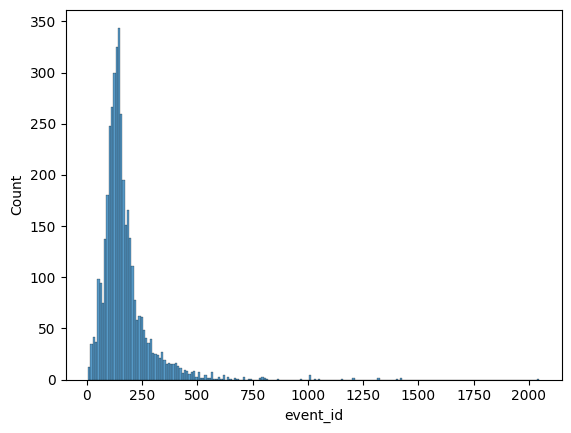

In [27]:
sns.histplot(events.groupby("pid")["event_id"].count())

In [28]:
 avg_norm_event_count = events.groupby("pid")["event_id"].count().mean()
 max_norm_event_count = events.groupby("pid")["event_id"].count().max()
 min_norm_event_count = events.groupby("pid")["event_id"].count().min()
 print(avg_norm_event_count)
 print(max_norm_event_count)
 print(min_norm_event_count)

170.66125
2046
6


In [31]:
print(hf.shape,events.shape)

(2960, 3) (682645, 4)


In [32]:
df_hf_events = pd.merge(hf, events, on="pid",how="left")
df_hf_events.head()

,pid,vid_x,label,event_id,vid_y,value
0,33,0,1,DIAG_244,0,1
1,33,0,1,DIAG_414,0,1
2,33,0,1,DIAG_427,0,1
3,33,0,1,DIAG_585,0,1
4,33,0,1,DIAG_V45,0,1


In [37]:
((df_hf_events["vid_x"] != df_hf_events["vid_y"]).sum()-df_hf_events.shape[0])/-df_hf_events.shape[0]

0.3599252577089163

In [38]:
df_hf_events.groupby("pid")["event_id"].count()

pid
33       122
64       132
156      187
181      165
199      572
        ... 
99784    222
99788    107
99825    238
99841    192
99971    143
Name: event_id, Length: 2960, dtype: int64

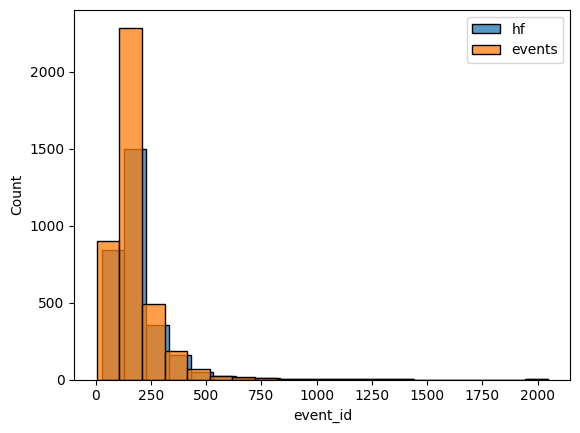

In [45]:
sns.histplot(df_hf_events.groupby("pid")["event_id"].count(),bins=20,label="hf")
sns.histplot(events.groupby("pid")["event_id"].count(),bins=20,label="events")
plt.legend()
plt.show()

In [46]:
 avg_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().mean()
 max_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().max()
 min_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().min()
 print(avg_hf_event_count)
 print(max_hf_event_count)
 print(min_hf_event_count)

188.9375
2046
28


In [96]:
def event_count_metrics(events, hf):

    '''
    TODO : Implement this function to return the event count metrics.

    Event count is defined as the number of events recorded for a given patient.
    '''
    df_hf_events = pd.merge(hf, events, on="pid",how="left")
    hf_pids = set(hf['pid'].unique())
    non_hf_events = events[~events['pid'].isin(hf_pids)]

    avg_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().mean()
    max_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().max()
    min_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().min()
    avg_norm_event_count = non_hf_events.groupby("pid")["event_id"].count().mean()
    max_norm_event_count = non_hf_events.groupby("pid")["event_id"].count().max()
    min_norm_event_count = non_hf_events.groupby("pid")["event_id"].count().min()

    # your code here
#     raise NotImplementedError

    return avg_hf_event_count, max_hf_event_count, min_hf_event_count, \
           avg_norm_event_count, max_norm_event_count, min_norm_event_count

In [97]:
event_count_metrics(events, hf)

(188.9375, 2046, 28, 118.64423076923077, 1014, 6)

In [71]:
 avg_hf_encounter_count = df_hf_events.groupby(["pid","vid_y"])["value"].count().mean()
 max_hf_encounter_count = df_hf_events.groupby(["pid","vid_y"])["value"].count().max()
 min_hf_encounter_count = df_hf_events.groupby(["pid","vid_y"])["value"].count().min()
 print(avg_hf_encounter_count)
 print(min_hf_encounter_count)
 print(max_hf_encounter_count)
 avg_norm_encounter_count = events.groupby(["pid","vid"])["value"].count().mean()
 max_norm_encounter_count = events.groupby(["pid","vid"])["value"].count().max()
 min_norm_encounter_count = events.groupby(["pid","vid"])["value"].count().min()
 print(avg_norm_encounter_count)
 print(max_norm_encounter_count)
 print(min_norm_encounter_count)

67.33144714664098
1
180
64.50392138335066
180
1


## ここがポイント‼‼‼‼
hf 以外の人の集計をする必要がある

In [102]:
hf['pid'].unique()

array([   33,    64,   156, ..., 99825, 99841, 99971])

In [105]:
hf_pids = set(hf['pid'].unique())

In [104]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [103]:
events['pid'].isin(hf_pids)

0         True
1         True
2         True
3         True
4         True
          ... 
682640    True
682641    True
682642    True
682643    True
682644    True
Name: pid, Length: 682645, dtype: bool

In [106]:
events[~events['pid'].isin(hf_pids)]

,pid,event_id,vid,value
254,78,DIAG_278,0,1
255,78,DIAG_285,0,1
256,78,DIAG_300,0,1
257,78,DIAG_311,0,1
258,78,DIAG_338,0,1
...,...,...,...,...
682067,99800,DRUG_0,1,1
682068,99800,DRUG_164,1,1
682069,99800,DRUG_28,1,1
682070,99800,DRUG_18,1,1


In [94]:
non_hf_events = events[~events['pid'].isin(hf_pids)]

In [95]:
non_hf_events.groupby("pid")["event_id"].count().mean()

118.64423076923077

In [98]:
def encounter_count_metrics(events, hf):

    '''
    TODO : Implement this function to return the encounter count metrics.

    Encounter count is defined as the number of visits recorded for a given patient.
    '''

    df_hf_events = pd.merge(hf, events, on="pid", how="left")
    hf_pids = set(hf['pid'].unique())
    non_hf_events = events[~events['pid'].isin(hf_pids)]

    hf_encounter_counts = df_hf_events.groupby("pid")["vid_y"].nunique()
    norm_encounter_counts = non_hf_events.groupby("pid")["vid"].nunique()

    avg_hf_encounter_count = hf_encounter_counts.mean()
    max_hf_encounter_count = hf_encounter_counts.max()
    min_hf_encounter_count = hf_encounter_counts.min()
    avg_norm_encounter_count = norm_encounter_counts.mean()
    max_norm_encounter_count = norm_encounter_counts.max()
    min_norm_encounter_count = norm_encounter_counts.min()

    # your code here
#     raise NotImplementedError

    return avg_hf_encounter_count, max_hf_encounter_count, min_hf_encounter_count, \
           avg_norm_encounter_count, max_norm_encounter_count, min_norm_encounter_count

In [99]:
encounter_count_metrics(events, hf)

(2.8060810810810812, 34, 2, 2.189423076923077, 11, 1)